
== Basic Statistics ==
count       350.000000
mean      33986.776971
std       92030.261472
min           0.000000
25%         339.260000
50%        2124.345000
75%        9274.560000
max      505845.660000
Name: consumption, dtype: float64

== Missing Values ==
Series([], dtype: int64)

== Yearly Consumption ==
meter_description                                   year
56A TE AWE AWE STREET,HOKOWHITU,PALMERSTON NORTH    2022       4750.81
                                                    2023       3506.71
                                                    2024       3517.71
AQUINAS 74 GLADSTONE ROAD,DUNEDIN                   2022     100175.72
                                                    2023     125758.03
                                                    2024     105619.96
ARANA 110 CLYDE STREET,DUNEDIN                      2022     108068.86
                                                    2023     104070.66
                                                    2024    

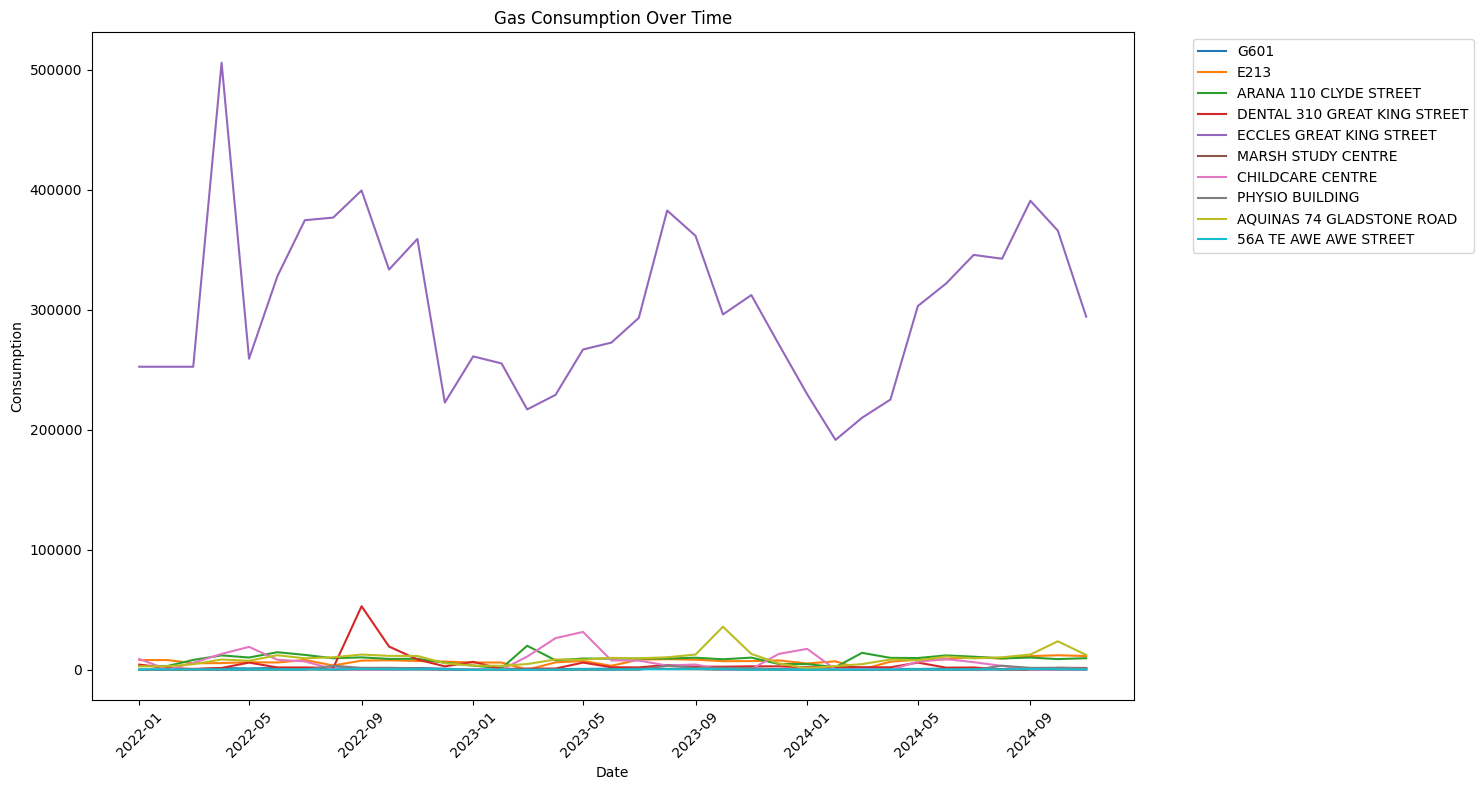

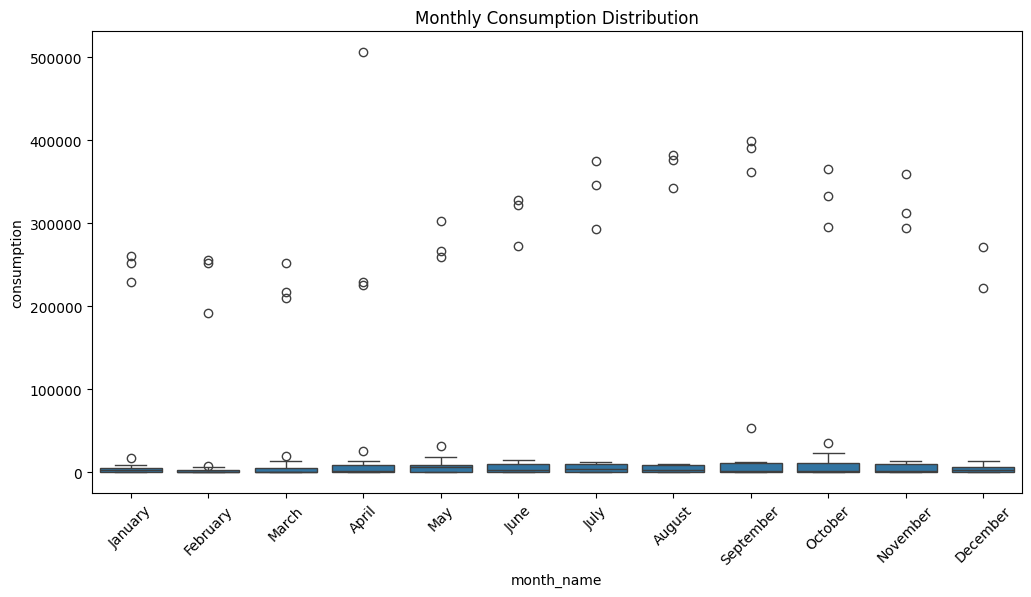

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

def load_and_prepare_data(file_path):
    # Read CSV file

    BASE_DIR = Path(os.getcwd()).parents[2]  # Get root directory
    METER_PATH = BASE_DIR / "backend/data/Cleaned" / file_path
    df = pd.read_csv(METER_PATH)


    # Melt the dataframe to convert months to rows
    df_melted = pd.melt(df, 
                        id_vars=['meter_description'],
                        var_name='month',
                        value_name='consumption')
    
    # Convert month column to datetime
    df_melted['month'] = pd.to_datetime(df_melted['month'], format='%b_%Y')
    
    return df, df_melted

def analyze_data(df, df_melted):
    """Perform comprehensive data analysis"""
    
    # 1. Basic Statistics
    print("\n== Basic Statistics ==")
    print(df_melted['consumption'].describe())
    
    # 2. Check for missing values
    print("\n== Missing Values ==")
    missing_values = df.isnull().sum()
    print(missing_values[missing_values > 0])
    
    # 3. Yearly Consumption Analysis
    df_melted['year'] = df_melted['month'].dt.year
    yearly_consumption = df_melted.groupby(['meter_description', 'year'])['consumption'].sum()
    print("\n== Yearly Consumption ==")
    print(yearly_consumption)
    
    return yearly_consumption

def plot_trends(df_melted):
    """Create visualizations"""
    
    # 1. Time Series Plot
    plt.figure(figsize=(15, 8))
    for building in df_melted['meter_description'].unique():
        data = df_melted[df_melted['meter_description'] == building]
        plt.plot(data['month'], data['consumption'], label=building.split(',')[0])
    
    plt.title('Gas Consumption Over Time')
    plt.xlabel('Date')
    plt.ylabel('Consumption')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.show()
    
    # 2. Box Plot for Monthly Distribution
    plt.figure(figsize=(12, 6))
    df_melted['month_name'] = df_melted['month'].dt.strftime('%B')
    sns.boxplot(x='month_name', y='consumption', data=df_melted)
    plt.title('Monthly Consumption Distribution')
    plt.xticks(rotation=45)
    plt.show()

# Main execution
try:
    # Load data
    df, df_melted = load_and_prepare_data("gas_automated_meter_cleaned.csv")
    
    # Perform analysis
    yearly_consumption = analyze_data(df, df_melted)
    
    # Create visualizations
    plot_trends(df_melted)
    
except Exception as e:
    print(f"Error in execution: {e}")


In [9]:
df_filtered = df[df['meter_description'] != 'ECCLES GREAT KING STREET,UNIVERSITY OF']
    
# Melt the dataframe to convert months to rows
df_melted = pd.melt(df_filtered, 
                    id_vars=['meter_description'],
                    var_name='month',
                    value_name='consumption')

# Convert month column to datetime
df_melted['month'] = pd.to_datetime(df_melted['month'], format='%b_%Y')
df_melted['year'] = df_melted['month'].dt.year

In [10]:
def calculate_yearly_differences(df_melted):
    # Calculate yearly consumption for each building
    yearly_consumption = df_melted.groupby(['meter_description', 'year'])['consumption'].sum().reset_index()
    
    # Pivot the data for easier comparison
    yearly_pivot = yearly_consumption.pivot(index='meter_description', 
                                          columns='year', 
                                          values='consumption')
    
    # Calculate differences and percentages
    yearly_pivot['Diff_2022_2023'] = yearly_pivot[2023] - yearly_pivot[2022]
    yearly_pivot['Pct_Change_2022_2023'] = (yearly_pivot['Diff_2022_2023'] / yearly_pivot[2022] * 100).round(2)
    
    yearly_pivot['Diff_2023_2024'] = yearly_pivot[2024] - yearly_pivot[2023]
    yearly_pivot['Pct_Change_2023_2024'] = (yearly_pivot['Diff_2023_2024'] / yearly_pivot[2023] * 100).round(2)
    
    return yearly_pivot

def create_plots(df_melted):
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    
    # Time Series Plot
    for building in df_melted['meter_description'].unique():
        data = df_melted[df_melted['meter_description'] == building]
        building_name = building.split(',')[0]  # Use first part of building name
        ax1.plot(data['month'], data['consumption'], label=building_name)
    
    ax1.set_title('Gas Consumption Over Time (Excluding ECCLES)')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Consumption')
    ax1.legend(bbox_to_anchor=(1.05, 1))
    ax1.tick_params(axis='x', rotation=45)
    
    # Yearly Comparison Bar Plot
    yearly_data = df_melted.groupby(['meter_description', 'year'])['consumption'].sum().reset_index()
    buildings = yearly_data['meter_description'].unique()
    x = np.arange(len(buildings))
    width = 0.25
    
    # Plot bars for each year
    ax2.bar(x - width, yearly_data[yearly_data['year'] == 2022]['consumption'], 
            width, label='2022')
    ax2.bar(x, yearly_data[yearly_data['year'] == 2023]['consumption'], 
            width, label='2023')
    ax2.bar(x + width, yearly_data[yearly_data['year'] == 2024]['consumption'], 
            width, label='2024')
    
    ax2.set_title('Yearly Consumption by Building')
    ax2.set_xlabel('Buildings')
    ax2.set_ylabel('Total Yearly Consumption')
    ax2.set_xticks(x)
    ax2.set_xticklabels([b.split(',')[0] for b in buildings], rotation=45, ha='right')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()


Yearly Consumption and Changes:
year                                                     2022       2023  \
meter_description                                                          
56A TE AWE AWE STREET,HOKOWHITU,PALMERSTON NORTH      4750.81    3506.71   
AQUINAS 74 GLADSTONE ROAD,DUNEDIN                   100175.72  125758.03   
ARANA 110 CLYDE STREET,DUNEDIN                      108068.86  104070.66   
CHILDCARE CENTRE,563 CASTLE STREET,DUNEDIN           64385.54  107013.02   
DENTAL 310 GREAT KING STREET,DUNEDIN NORTH,DUNEDIN  103409.88   34616.10   
E213,PARKER BUILDING,344 GREAT KING                  81321.25   77093.82   
G601,UNIVERSITY COLLEGE (KITCHEN),315 LEITH          12334.47    7814.27   
MARSH STUDY CENTRE,CASTLE STREET,DUNEDIN              1659.72    2976.87   
PHYSIO BUILDING, 325 GREAT KING ST                    7948.00    7948.00   

year                                                     2024  Diff_2022_2023  \
meter_description                                

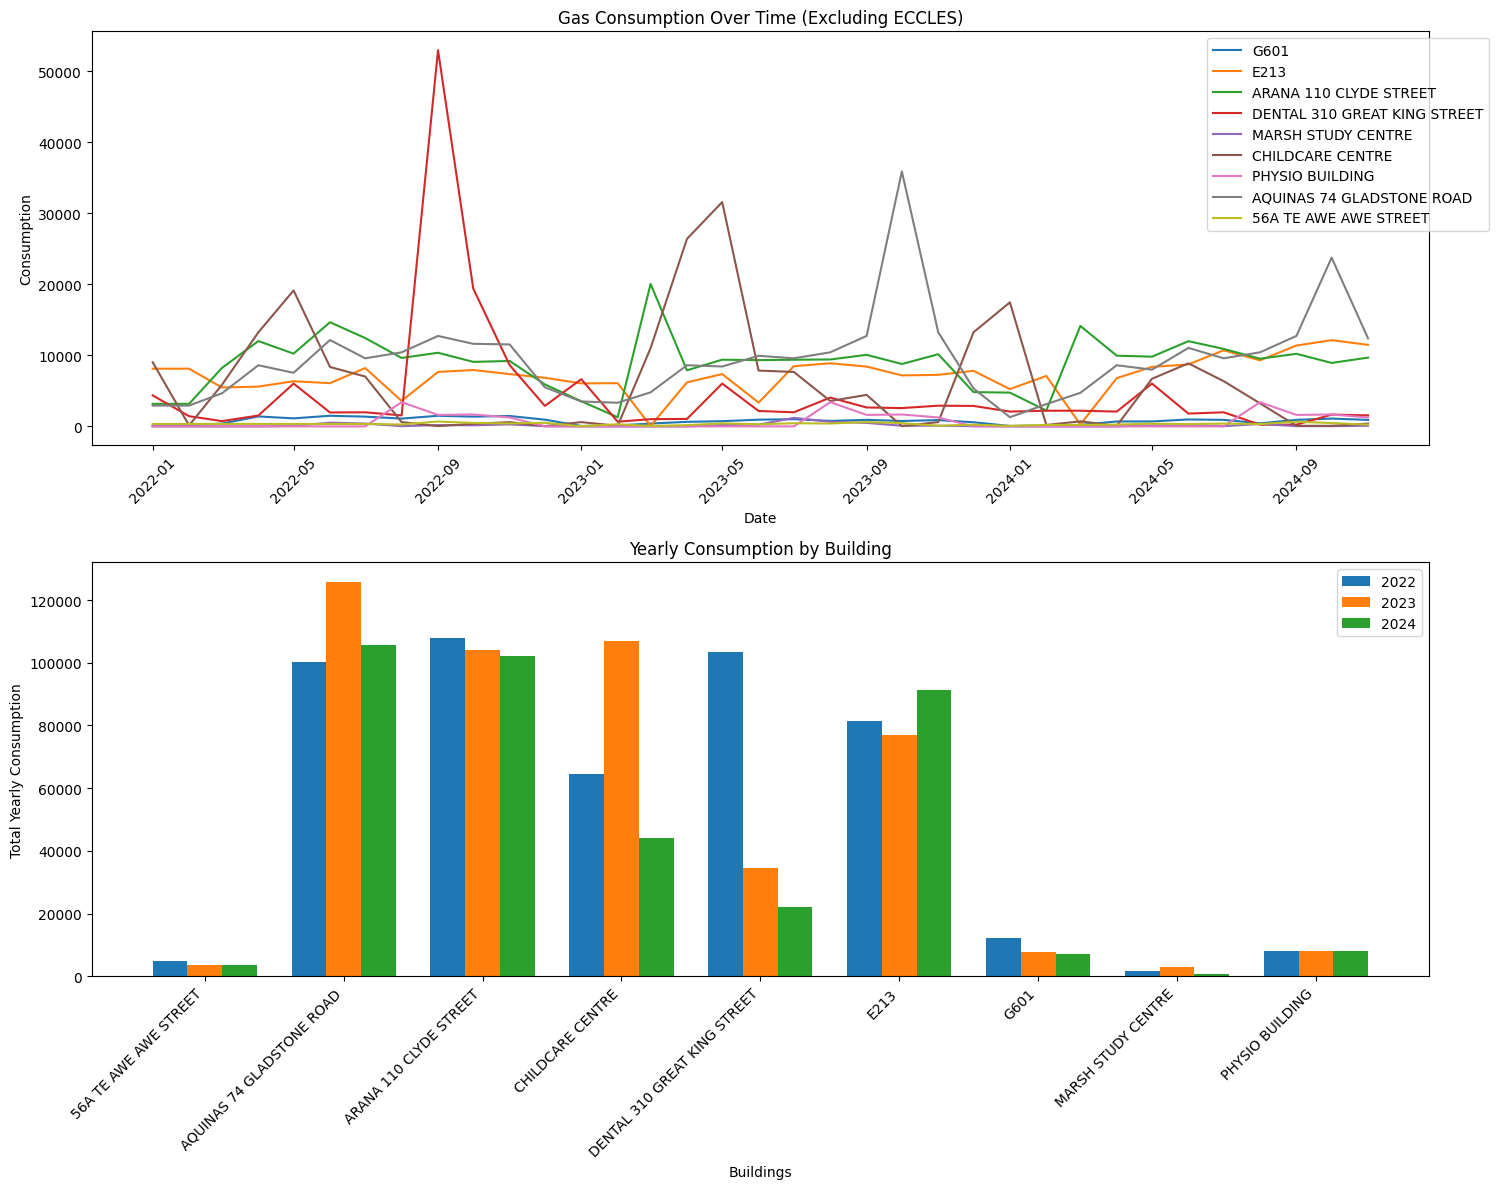

In [11]:
yearly_comparison = calculate_yearly_differences(df_melted)
print("\nYearly Consumption and Changes:")
print(yearly_comparison)

# Create visualizations
create_plots(df_melted)